# Introduction

The following is an analysis of the rent prices in Germany, specially for the capital of Nordrhein-Westfalen (Düsseldorf)

I aim to answer three question:
1. How expensive is to live in Düsseldorf compare to any other city in Nordrhein-Westfalen (NRW)?
2. How is the distribution of rent prices in the city? if we look for a specific borough/neighborhood and a given size?
3. How do the characteristics of a flat explain the variability in prize?

Bonus question:
4. Can the rent prices in Düsseldorf be accurately predicted using a linear model?

This Notebook contains all the graphics shown in the article **add address**

In [1]:
# import all necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [26]:
# import the data 
df = pd.read_csv('immo_data_clean.csv')

# test
print(df.shape)

(265617, 31)


In [27]:
def get_rid_outl(df, list_num_var, percentile):
    """
    INPUT: 
    df: Dataframe
    list_num_var: List of the variables (columns) with outliers that need to be deleted
    percentile: float between 0 and 100: Percentage of the data that will be kept 
    
    OUTPUT:
    DataFrame with the defined amount of data. This means a DataFrame without outliers
    """
    
    perc_dict = {}
    for col in list_num_var: # first, calculate all the percentiles before removing any
        # row, otherwise you will remove more rows than necessary
        value_perc = np.nanpercentile(df[col], percentile)
        value_perc_dict = {col: value_perc}
        perc_dict.update(value_perc_dict)
        
    for var in list_num_var:    
        df = df.loc[(df[var] <= perc_dict[var]) ^ (df[var].isnull())] # include nan values
    
    return df

In [28]:
# do necessary changes to dataframe
# drop columns
df.drop(columns=['totalRent',
                 'baseRent',
                 'serviceCharge',
                 'total_rent_new',
                 'heatingCosts'], inplace=True)

# rename the response variable to rent
df.rename(columns={'rent_incl_hc': 'rent'}, inplace=True)

# remove all rows where living space is 0
df = df[df['livingSpace'] != 0]

# create a new variable for the rent/livingSpace (rent/m2)
df['rent_m2'] = df['rent'] / df['livingSpace']

# get rid of outliers
df = get_rid_outl(df, ['rent_m2'], 99.8)

In [29]:
# create subsets for NRW and Düsseldorf

df_nrw = df[df.regio1 == 'Nordrhein_Westfalen'].copy()
df_dus = df[df.regio2 == 'Düsseldorf'].copy()

# test
print(df_nrw.shape)
print(df_dus.shape)

(62315, 27)
(3624, 27)


First Graph: overview of offers accross germany

''

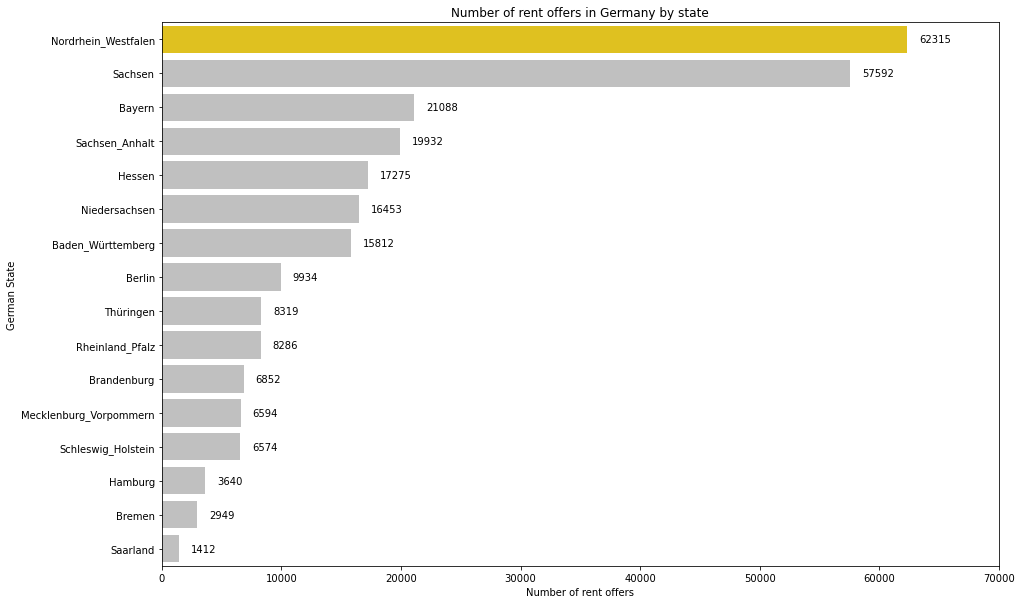

In [30]:
order_bundeslander = df.regio1.value_counts().sort_values(ascending=False).index

plt.figure(figsize=[15, 10])
coloring_bundeslander = ['gold' if x == 'Nordrhein_Westfalen' else 'silver' for x in order_bundeslander]
sns.countplot(data=df, y='regio1', order=order_bundeslander, palette=coloring_bundeslander)
plt.title('Number of rent offers in Germany by state')
plt.ylabel('German State')
plt.xlabel('Number of rent offers')
plt.xlim(0,70000)
offers_region = list(df.regio1.value_counts().sort_values(ascending=False))
for i in range(len(offers_region)):
    count = offers_region[i]
    plt.text(count+1000, i, count, va='center');
;

Second Graph: mean prices for each city in NRW focus DUS

''

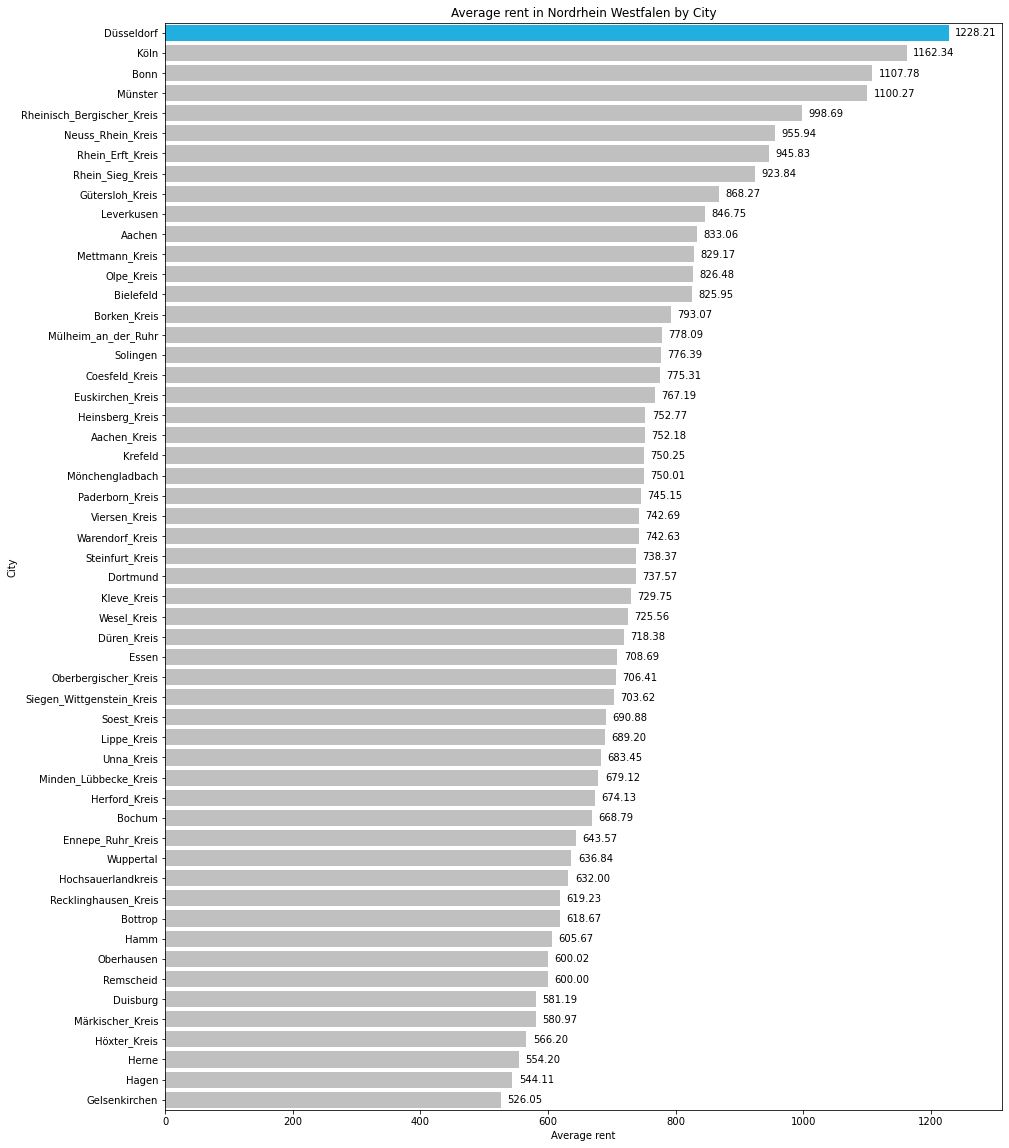

In [42]:
order_cities_nrw = df_nrw.groupby(['regio2']).rent.mean().sort_values(ascending=False).index

plt.figure(figsize=[15, 20])
coloring_cities_nrw = ['deepskyblue' if x == 'Düsseldorf' else 'silver' for x in order_cities_nrw]
sns.barplot(data=df_nrw, y='regio2', x='rent', errwidth=0, order=order_cities_nrw, palette=coloring_cities_nrw)
plt.title('Average rent in Nordrhein Westfalen by City')
plt.ylabel('City')
plt.xlabel('Average rent')
rent_city = list(df_nrw.groupby(['regio2']).rent.mean().sort_values(ascending=False))
for i in range(len(rent_city)):
    count = rent_city[i]
    plt.text(count+10, i, format(count, '0.2f'), va='center');
;

Graph 3: Distribution of the prices for each borough in the city of Düsseldorf

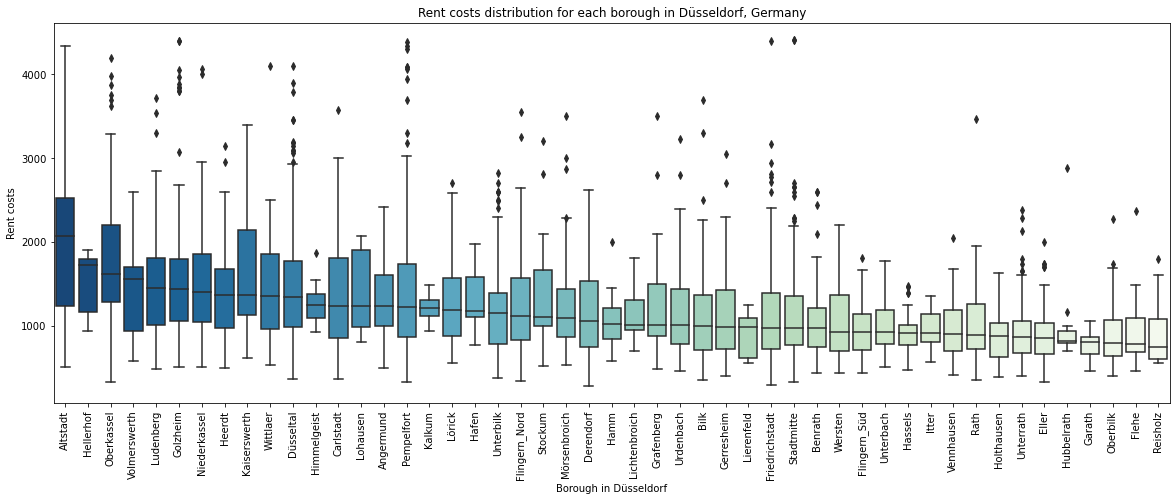

In [54]:
rent_borough_order = df_dus.groupby(['regio3']).rent.median().sort_values(ascending=False).index

plt.figure(figsize=[20,7])
sns.boxplot(data=df_dus, x='regio3', y='rent', order=rent_borough_order, palette='GnBu_r')
plt.title('Rent costs distribution for each borough in Düsseldorf, Germany')
plt.ylabel('Rent costs')
plt.xlabel('Borough in Düsseldorf')
plt.xticks(rotation=90);

In [253]:
rent_borough_order

Index(['Altstadt', 'Hellerhof', 'Oberkassel', 'Volmerswerth', 'Ludenberg',
       'Golzheim', 'Niederkassel', 'Heerdt', 'Kaiserswerth', 'Wittlaer',
       'Düsseltal', 'Himmelgeist', 'Carlstadt', 'Lohausen', 'Angermund',
       'Pempelfort', 'Kalkum', 'Lörick', 'Hafen', 'Unterbilk', 'Flingern_Nord',
       'Stockum', 'Mörsenbroich', 'Derendorf', 'Hamm', 'Lichtenbroich',
       'Grafenberg', 'Urdenbach', 'Bilk', 'Gerresheim', 'Lierenfeld',
       'Friedrichstadt', 'Stadtmitte', 'Benrath', 'Wersten', 'Flingern_Süd',
       'Unterbach', 'Hassels', 'Itter', 'Vennhausen', 'Rath', 'Holthausen',
       'Unterrath', 'Eller', 'Hubbelrath', 'Garath', 'Oberbilk', 'Flehe',
       'Reisholz'],
      dtype='object', name='regio3')

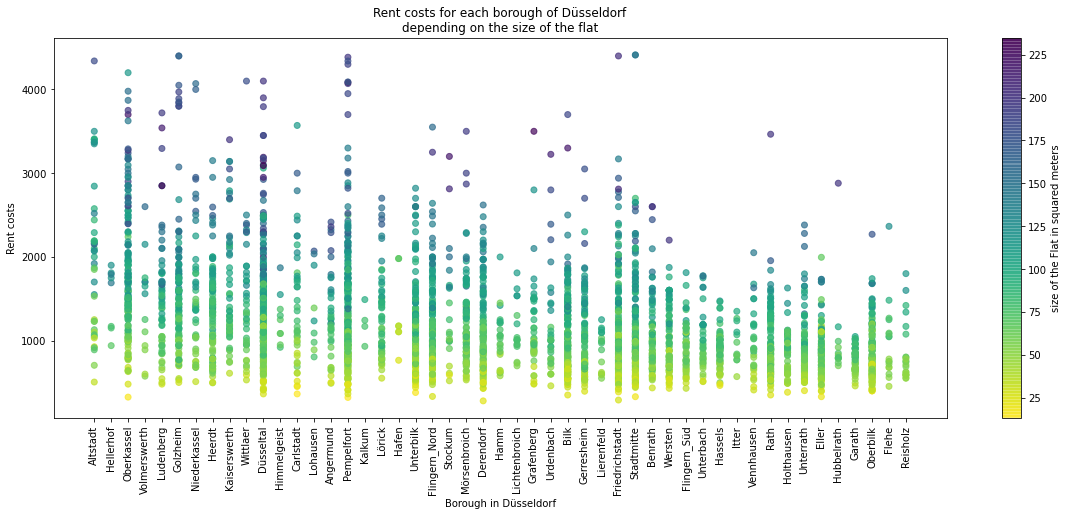

In [258]:
df_dus_copy = df_dus.copy()

# set the order of the cities
cat_dict = {}
count = 0

for cat in rent_borough_order:
    count += 1
    value_dict = {cat: count}
    cat_dict.update(value_dict)
    
# create a new column with the right order
df_dus_copy['regio3_num'] = df_dus_copy['regio3'].apply(lambda x: cat_dict[x])

# plot the graph
plt.figure(figsize=[20,7])
plt.scatter(data=df_dus_copy, x='regio3_num', y='rent', c='livingSpace', cmap='viridis_r', alpha=0.7)
plt.xticks(np.arange(1, len(cat_dict)+1, 1), rent_borough_order, rotation=90)
plt.title('Rent costs for each borough of Düsseldorf\ndepending on the size of the flat')
plt.ylabel('Rent costs')
plt.xlabel('Borough in Düsseldorf')
cb = plt.colorbar()
cb.set_label('size of the Flat in squared meters');

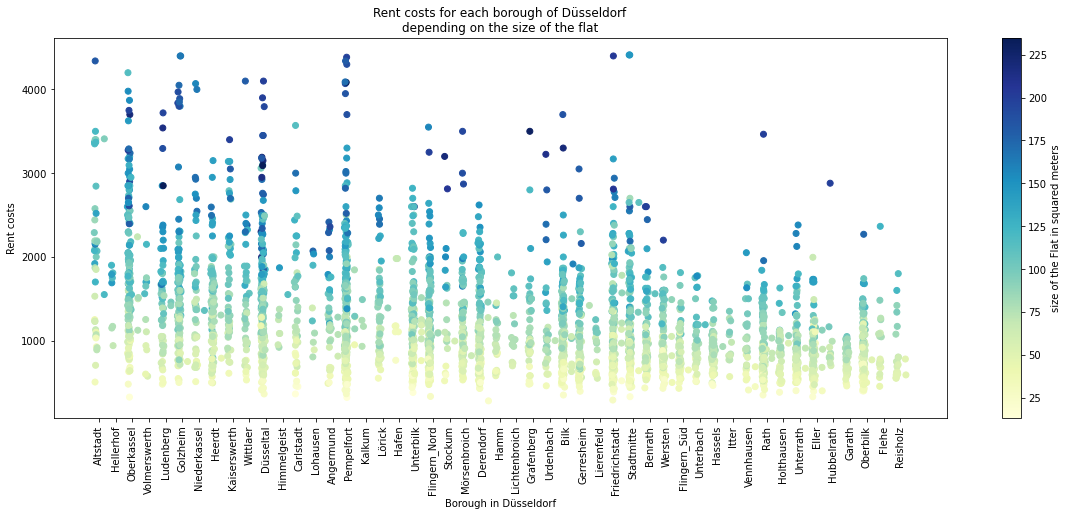

In [468]:
# add jitter to the graph to see the variation better 

df_dus_copy = df_dus.copy()

# set the order of the cities
cat_dict = {}
count = 0

for cat in rent_borough_order:
    count += 1
    value_dict = {cat: count}
    cat_dict.update(value_dict)
    
# create a new column with the right order
df_dus_copy['regio3_num'] = df_dus_copy['regio3'].apply(lambda x: cat_dict[x])

# reset the index of the dataset
df_dus_copy.reset_index(inplace=True)

# create a column with random numbers to simulate the jitter
jitter = pd.Series(np.random.normal(0.2,0.05,len(df_dus_copy)))

# concatenate the new columns
df_dus_copy_jitter = pd.concat([df_dus_copy, jitter], axis=1)

# create a column with the jittered values
df_dus_copy_jitter['regio3_jitter'] = df_dus_copy_jitter.apply(lambda x: x['regio3_num'] + x[0] if x[0] > 0.3 else x['regio3_num'] - x[0], axis=1) 

# Plot the figure 
plt.figure(figsize=[20,7])
plt.scatter(data=df_dus_copy_jitter, x='regio3_jitter', y='rent', c='livingSpace', cmap='YlGnBu')
plt.xticks(np.arange(1, len(cat_dict)+1, 1), rent_borough_order, rotation=90)
plt.title('Rent costs for each borough of Düsseldorf\ndepending on the size of the flat')
plt.ylabel('Rent costs')
plt.xlabel('Borough in Düsseldorf')
cb = plt.colorbar()
cb.set_label('size of the Flat in squared meters');

Graph 4 some multidimensional plots

In [300]:
df_dus.typeOfFlat.replace(np.nan, 'NO_INFORMATION', inplace=True)
df_dus.interiorQual.replace(np.nan, 'NO_INFORMATION', inplace=True)

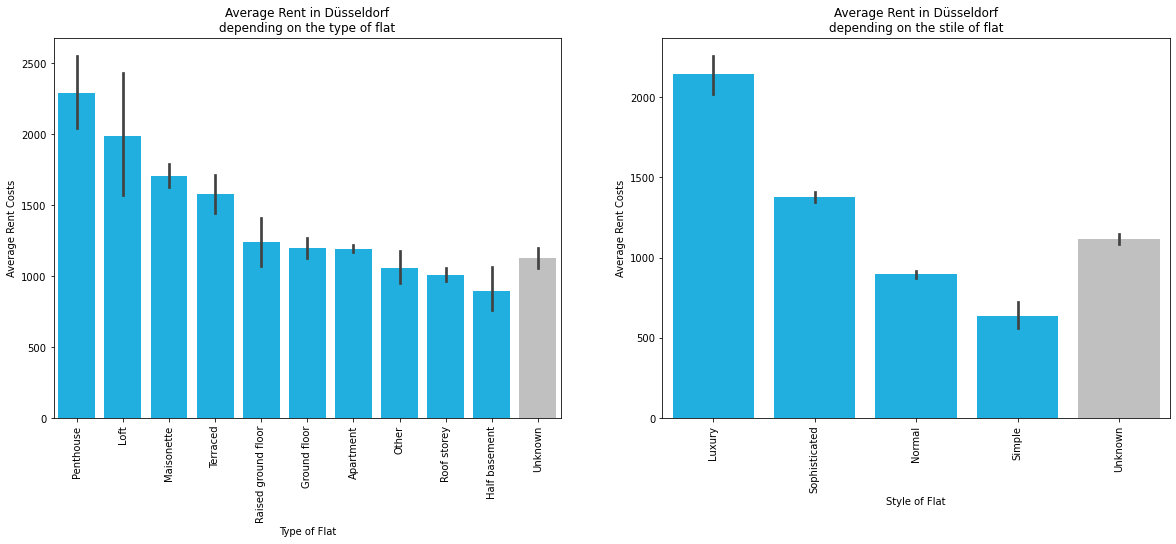

In [306]:
# first graph
flat_order = ['penthouse', 'loft', 'maisonette', 
              'terraced_flat', 'raised_ground_floor', 
              'ground_floor', 'apartment', 
              'other', 'roof_storey', 'half_basement', 'NO_INFORMATION']
coloring_flats = ['silver' if x == 'NO_INFORMATION' else 'deepskyblue' for x in flat_order]
flat_x_labels = ['Penthouse', 'Loft', 'Maisonette', 
            'Terraced', 'Raised ground floor', 
            'Ground floor', 'Apartment', 
            'Other', 'Roof storey', 'Half basement', 'Unknown']

plt.figure(figsize=[20,7])
plt.subplot(1,2,1)
sns.barplot(data=df_dus, x='typeOfFlat', y='rent', order=flat_order,
              palette=coloring_flats)
plt.xticks(np.arange(0, len(flat_x_labels), 1), flat_x_labels, rotation=90)
plt.title('Average Rent in Düsseldorf\ndepending on the type of flat')
plt.ylabel('Average Rent Costs')
plt.xlabel('Type of Flat')

# second graph
interior_order = ['luxury', 'sophisticated', 'normal', 'simple', 'NO_INFORMATION']
interior_x_labels = ['Luxury', 'Sophisticated', 'Normal', 'Simple', 'Unknown']
coloring_interior = ['silver' if x == 'NO_INFORMATION' else 'deepskyblue' for x in interior_order]

plt.subplot(1,2,2)
sns.barplot(data=df_dus, x='interiorQual', y='rent', order=interior_order,
              palette=coloring_interior)
plt.xticks(np.arange(0, len(interior_x_labels), 1), interior_x_labels, rotation=90)
plt.title('Average Rent in Düsseldorf\ndepending on the stile of flat')
plt.ylabel('Average Rent Costs')
plt.xlabel('Style of Flat');

Graph 5: the last graphs

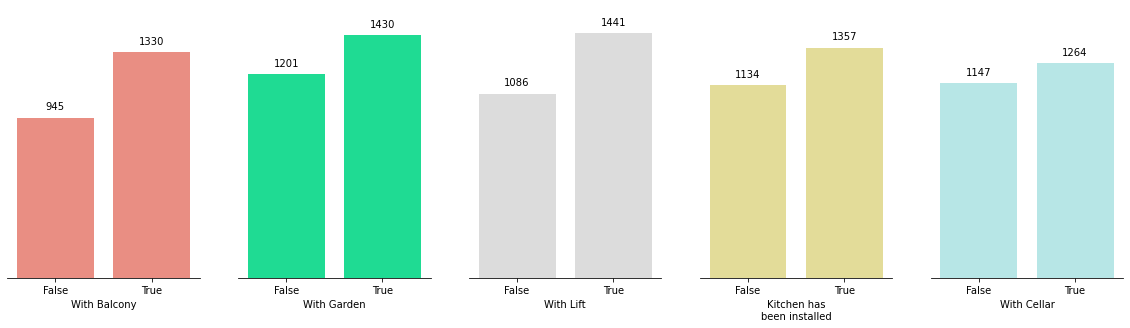

In [352]:
vars_of_interest = ['balcony', 'garden', 'lift', 'hasKitchen', 'cellar']
x_labels = {'balcony': 'With Balcony', 
          'hasKitchen': 'Kitchen has\nbeen installed', 
          'cellar': 'With Cellar', 
          'lift': 'With Lift', 
          'garden': 'With Garden'}
colors = {'balcony': 'salmon', 
          'hasKitchen': 'khaki', 
          'cellar': 'paleturquoise', 
          'lift': 'gainsboro', 
          'garden': 'mediumspringgreen'}

plt.figure(figsize=[20,5])
count = 0
for var in vars_of_interest:
    value_var = df_dus.groupby([var]).rent.mean()
    count += 1
    plt.subplot(1,5,count)
    sns.barplot(data=df_dus, x=var, y='rent', color=colors[var], errwidth=0)
    plt.xlabel(x_labels[var])
    plt.ylim((0,1600))
    plt.yticks([])
    plt.ylabel(None)
    sns.despine(left=True, right=True)
    # get the values for each bar
    for i in range(value_var.shape[0]):
        average = value_var[i]
        plt.text(i, average+50, format(average, '0.0f'), ha='center');

Final Thought: Fitting a linear regression:

In [356]:
# import necessary libraries
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [469]:
# create a copy of the dataset to run the regression 
df_dus_reg = df_dus.copy()
df_dus_reg.drop(columns=['date', 'geo_plz', 'rent_m2'], inplace=True) # dropping unnecessary columns

In [470]:
# first transform all categorical values into dummies
list_cat_vars = df_dus_reg.select_dtypes(include = ['object']).columns

for var in  list_cat_vars:
    # for each cat add dummy var, drop original column
    df_dus_reg = pd.concat([df_dus_reg.drop(var, axis=1), pd.get_dummies(df_dus_reg[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)

df_dus_reg.describe()

,Unnamed: 0,noParkSpaces,livingSpace,noRooms,rent,heatingType_combined_heat_and_power_plant,heatingType_district_heating,heatingType_electric_heating,heatingType_floor_heating,heatingType_gas_heating,...,lastRefurbish_2012,lastRefurbish_2013,lastRefurbish_2014,lastRefurbish_2015,lastRefurbish_2016,lastRefurbish_2017,lastRefurbish_2018,lastRefurbish_2019,lastRefurbish_2020,lastRefurbish_NO_INFORMATION
count,3624.000000,3624.000000,3624.000000,3624.000000,3624.000000,3624.000000,3624.000000,3624.000000,3624.000000,3624.000000,...,3624.000000,3624.000000,3624.000000,3624.000000,3624.000000,3624.000000,3624.000000,3624.000000,3624.000000,3624.000000
mean,137677.096578,0.386038,80.993562,2.572710,1228.214658,0.005795,0.073400,0.002759,0.099614,0.097682,...,0.010486,0.013797,0.014901,0.024558,0.027870,0.035320,0.065673,0.116722,0.020143,0.630519
std,78290.911174,0.803479,34.472973,0.931788,632.690682,0.075913,0.260827,0.052465,0.299526,0.296925,...,0.101875,0.116663,0.121172,0.154797,0.164622,0.184613,0.247744,0.321133,0.140510,0.482731
min,81.000000,0.000000,13.000000,1.000000,280.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,71285.500000,0.000000,57.000000,2.000000,780.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,140934.000000,0.000000,75.275000,2.500000,1050.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,203547.750000,1.000000,99.507500,3.000000,1504.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,268803.000000,30.000000,235.000000,6.000000,4412.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [471]:
# set the matrices
y = df_dus_reg['rent']
X = df_dus_reg[[i for i in df_dus_reg.columns if i != 'rent']]

In [479]:
# set the training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)  

In [480]:
# fit the modell
lm_model = LinearRegression(normalize=True)
result = lm_model.fit(X_train, y_train)

In [481]:
# get the r_score
result.score(X_train, y_train)

0.886958884945071

This is a great result for the train set, since the linear model explains almost 90% of the variability of the rent price. Now I will compare this result to the test set and control for overfitting

In [379]:
### Let's see what be the best number of features to use based on the test set performance
def find_optimal_lm_mod(X, y, cutoffs, test_size = .30, random_state=42, plot=True):
    '''
    INPUT
    X - pandas dataframe, X matrix
    y - pandas dataframe, response variable
    cutoffs - list of ints, cutoff for number of non-zero values in dummy categorical vars
    test_size - float between 0 and 1, default 0.3, determines the proportion of data as test data
    random_state - int, default 42, controls random state for train_test_split
    plot - boolean, default 0.3, True to plot result
    
    OUTPUT
    r2_scores_test - list of floats of r2 scores on the test data
    r2_scores_train - list of floats of r2 scores on the train data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    '''
    r2_scores_test, r2_scores_train, num_feats, results = [], [], [], dict()
    for cutoff in cutoffs:
        
        #reduce X matrix
        reduce_X = X.iloc[:, np.where((X.sum() > cutoff) == True)[0]]
        num_feats.append(reduce_X.shape[1])

        #split the data into train and test
        X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

        #fit the model and obtain pred response
        lm_model = LinearRegression(normalize=True) 
        lm_model.fit(X_train, y_train)
        y_test_preds = lm_model.predict(X_test)
        y_train_preds = lm_model.predict(X_train)
        
        #append the r2 value from the test set
        r2_scores_test.append(r2_score(y_test, y_test_preds))
        r2_scores_train.append(r2_score(y_train, y_train_preds))
        results[str(cutoff)] = r2_score(y_test, y_test_preds)
    
    if plot:
        plt.plot(num_feats, r2_scores_test, label="Test", alpha=.5)
        plt.plot(num_feats, r2_scores_train, label="Train", alpha=.5)
        plt.xlabel('Number of Features')
        plt.ylabel('Rsquared')
        plt.title('Rsquared by Number of Features')
        plt.legend(loc=1)
        plt.show()
        
    best_cutoff = max(results, key=results.get)
    
    #reduce X matrix
    reduce_X = X.iloc[:, np.where((X.sum() > int(best_cutoff)) == True)[0]]
    num_feats.append(reduce_X.shape[1])

    #split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

    #fit the model
    lm_model = LinearRegression(normalize=True) 
    lm_model.fit(X_train, y_train)
        
    return r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test

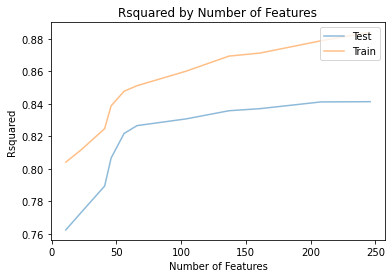

In [462]:
cutoffs = [1000, 500, 250, 200, 150, 100, 50, 30, 20, 10, 5]
r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test = find_optimal_lm_mod(X, y, cutoffs)